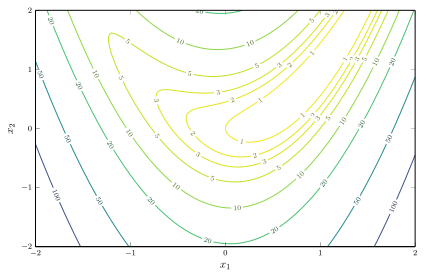

In [1]:
# Conjugate Gradient
using LinearAlgebra, Dates

###################################################################################
using Plots, LaTeXStrings, Printf
pgfplotsx() #pyplot()

# add PGFPlotsX (Textlive, MikTeX)

# Rosenbrock function
fp(x1,x2) = (1 - x1)^2 + 5*(x2 - x1^2)^2

x1 = -2:0.05:2
x2 = -2:0.05:2

pl1 = contour(x1, x2, fp, framestyle = :box,
    levels = [1,2,3,5,10,20,50,100], 
    c = cgrad(:viridis, rev = true, scale = :exp),
    ylab = L"x_2", 
    xlab = L"x_1",
    xlims = (-2,2),
    ylims = (-2,2),
    legend = false,
    grid = false,
    contour_labels = true,
    label = false)

In [3]:
function bracket_minimum(f, x=0; s=1e-2, k=2.0)
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end

    while true
        c, yc = b + s, f(b + s)
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end

using Base.MathConstants
function fibonacci_search(f, a, b, n; ϵ=0.002)
    s = (1-√5)/(1+√5)
    ρ = 1 / (φ*(1-s^(n+1))/(1-s^n))
    d = ρ*b + (1-ρ)*a
    yd = f(d)
    for i in 1 : n-1
        if i == n-1
            c = ϵ*a + (1-ϵ)*d
        else
            c = ρ*a + (1-ρ)*b
        end
        yc = f(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        ρ = 1 / (φ*(1-s^(n-i+1))/(1-s^(n-i)))
    end
    return a < b ? (a, b) : (b, a)
end

fibonacci_search (generic function with 1 method)

In [4]:
# Define function, gradient and hessian
f = x -> (1-x[1])^2 + 5*(x[2] - x[1]^2)^2
∇f = x -> [2*(10*x[1]^3-10*x[1]*x[2]+x[1]-1), 10*(x[2]-x[1]^2)]

x0 = [-1,-1]

# Iteration = 1
g0 = ∇f(x0)
d0 = -g0

# Choose step size
objective = α -> f(x0 + α*d0)
a, b = bracket_minimum(objective)
α = fibonacci_search(objective, a, b, 100)

x1 = x0 + α[1]*d0

2-element Array{Float64,1}:
  0.35397919799037525
 -0.3845549100043748

In [5]:
# Iteration = 2
g1 = ∇f(x1)
β = max(0.0, dot(g1, g1-g0)/dot(g0,g0))
d1 = -g1 + β*d0

# Choose step size
objective = α -> f(x1 + α*d1)
a, b = bracket_minimum(objective)
α = fibonacci_search(objective, a, b, 100)

x2 = x1 + α[1]*d1

2-element Array{Float64,1}:
 0.22754888271731075
 0.008423244394122065

In [6]:
# Iteration = 3
g2 = ∇f(x2)
β = max(0.0, dot(g2, g2-g1)/dot(g1,g1))
d2 = -g2 + β*d1

# Choose step size
objective = α -> f(x2 + α*d2)
a, b = bracket_minimum(objective)
α = fibonacci_search(objective, a, b, 100)

x3 = x2 + α[1]*d2

2-element Array{Float64,1}:
 0.6899776804869467
 0.371736073656059

In [7]:
function bracket_minimum(f, x=0; s=1e-2, k=2.0)
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end

    while true
        c, yc = b + s, f(b + s)
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end

using Base.MathConstants
function fibonacci_search(f, a, b, n; ϵ=0.002)
    s = (1-√5)/(1+√5)
    ρ = 1 / (φ*(1-s^(n+1))/(1-s^n))
    d = ρ*b + (1-ρ)*a
    yd = f(d)
    for i in 1 : n-1
        if i == n-1
            c = ϵ*a + (1-ϵ)*d
        else
            c = ρ*a + (1-ρ)*b
        end
        yc = f(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        ρ = 1 / (φ*(1-s^(n-i+1))/(1-s^(n-i)))
    end
    return a < b ? (a, b) : (b, a)
end

fibonacci_search (generic function with 1 method)

In [8]:
function conjugate_gradient(f, ∇f, x0; ϵ = 0.00001, iters = false, plotFig = false, plotFile = false)
    
    # Iteration = 1
    g0 = ∇f(x0)
    d0 = -g0

    # Choose step size
    objective = α -> f(x0 + α*d0)
    a, b = bracket_minimum(objective)
    α = fibonacci_search(objective, a, b, 100)

    x = x0 + α[1]*d0
    
    ϵ0 = 1000
    
    i = 0
    while ϵ0 > ϵ
        # Direction
        g1 = ∇f(x)
        β = max(0.0, dot(g1, g1-g0)/dot(g0,g0))
        d1 = -g1 + β*d0

        # Choose step size
        objective = α -> f(x + α*d1)
        a, b = bracket_minimum(objective)
        α = fibonacci_search(objective, a, b, 100)

        xn = x + α[1]*d1
    
        y1 = f(x)
        y2 = f(xn)
        
        # Error
        ϵ0 = abs(y2 - y1)
        
        i += 1
        if iters == true
            if i == 1
                println("=="^49)
                timenow = Dates.now()
                timenow1 = Dates.format(timenow, "dd u yyyy HH:MM:SS")
                println(":: Conjugated Gradient Method :: ", timenow1)
                println("=="^49)
                println(@sprintf("Iter\t x(k)\t\t\t x(k+1)\t\t\t f(xk)\t\t f(xk+1)\t ϵ"))
                println("=="^49)
            end
            
            xs = map(x -> @sprintf("%2.3f",x), x)
            xns = map(x -> @sprintf("%2.3f",x), xn)
            println(@sprintf("%i\t %s\t %s\t %1.3e\t %1.3e\t %1.3e", i, xs, xns, y1, y2, ϵ0)) 
        end
        
        if plotFig == true
            plot!([x[1], xn[1]], [x[2], xn[2]], label="", xlims = (-2,2), ylims = (-2,2))
        end
        g0 = g1
        d0 = d1
        x = xn
    end
    
    if iters == true
        println("=="^49)
    end
    
    if plot != false
        if plotFig == true
            display((pl1))
        end
    end
    return x, f(x)
end

conjugate_gradient (generic function with 1 method)

:: Conjugated Gradient Method :: 16 Jan 2021 17:58:34
Iter	 x(k)			 x(k+1)			 f(xk)		 f(xk+1)	 ϵ
1	 ["-1.407", "2.138"]	 ["-1.125", "1.018"]	 5.919e+00	 4.821e+00	 1.098e+00
2	 ["-1.125", "1.018"]	 ["-0.748", "0.141"]	 4.821e+00	 3.937e+00	 8.843e-01
3	 ["-0.748", "0.141"]	 ["0.515", "0.169"]	 3.937e+00	 2.816e-01	 3.655e+00
4	 ["0.515", "0.169"]	 ["0.513", "0.261"]	 2.816e-01	 2.373e-01	 4.433e-02
5	 ["0.513", "0.261"]	 ["0.790", "0.548"]	 2.373e-01	 7.339e-02	 1.639e-01
6	 ["0.790", "0.548"]	 ["0.955", "0.932"]	 7.339e-02	 4.275e-03	 6.912e-02
7	 ["0.955", "0.932"]	 ["0.992", "0.981"]	 4.275e-03	 9.608e-05	 4.179e-03
8	 ["0.992", "0.981"]	 ["1.000", "1.000"]	 9.608e-05	 8.534e-07	 9.523e-05
9	 ["1.000", "1.000"]	 ["1.000", "1.001"]	 8.534e-07	 7.444e-08	 7.790e-07


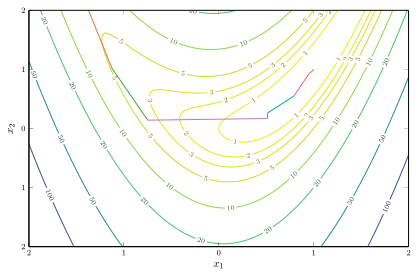

([1.0002683892237496, 1.0005587761968988], 7.443646067231364e-8)

In [9]:
x = [-2,2]

conjugate_gradient(f, ∇f, x; iters = true, plotFig = true, plotFile = pl1)